In [1]:
#Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tfms
import torchvision.models as models
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Defining data transformations for training data
data_transforms = tfms.Compose([
        tfms.Resize(240),
        tfms.CenterCrop(240),
        tfms.ToTensor(),
    ])

In [3]:
#creating datasets of real photos and sketches
real_dataset = datasets.ImageFolder('../data/cuhk/reals/', data_transforms)
sketch_dataset = datasets.ImageFolder('../data/cuhk/sketches/', data_transforms)

In [4]:
#dataloaders for datasets
real_data_loader = torch.utils.data.DataLoader(real_dataset, batch_size=1, num_workers=4) 
sketch_data_loader = torch.utils.data.DataLoader(sketch_dataset, batch_size=4, num_workers=4) 

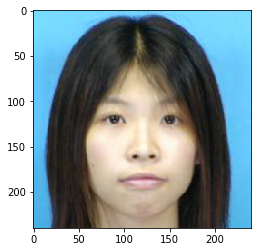

In [5]:
#real photo
imgs = next(iter(real_data_loader))
plt.figure()
plt.imshow(np.transpose(imgs[0][0].numpy(), (1, 2, 0)))
plt.show()

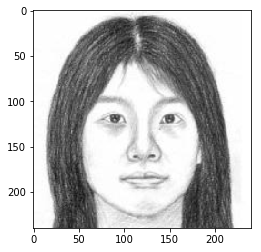

In [6]:
#sketch photo
imgs = next(iter(sketch_data_loader))
plt.figure()
plt.imshow(np.transpose(imgs[0][0].numpy(), (1, 2, 0)))
plt.show()

In [7]:
#Normal Residual block
class Res(nn.Module):
    def __init__(self):
        super(Res, self).__init__()
        self.conv1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out) + x
        
        return out

In [8]:
#Residual block without adding input at the end
class Res1(nn.Module):
    def __init__(self):
        super(Res1, self).__init__()
        self.conv1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = F.relu(self.bn2(out))
        
        return out

In [9]:
#Defining our network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.c1 = nn.Sequential(nn.Conv2d(3, 32, 9, stride=1, padding=4),
                          nn.BatchNorm2d(32),
                          nn.ReLU())
        self.c2 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=2, padding=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU())
        self.c3 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=2, padding=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU())
        
        self.res = nn.Sequential(Res1(), Res(), Res(), Res(), Res())
        
        self.d1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU())
        self.d2 = nn.Sequential(nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
                          nn.BatchNorm2d(32),
                          nn.ReLU())
        self.d3 = nn.Sequential(nn.Conv2d(32, 3, 9, stride=1, padding=4),
                          nn.BatchNorm2d(3),
                          nn.Tanh())

    def forward(self, x):
        out = self.c1(x)
        out = self.c2(out) 
        out = self.c3(out) 
        out = self.res(out)
        out = self.d1(out)
        out = self.d2(out)
        out = self.d3(out)
        
        return out

In [10]:
#creating an instance of the network/model
model = Net().cuda()

In [11]:
#hyperparameters
lr = 0.001
num_epochs = 50

In [12]:
#defining loss function, criterion and importing pretrained vgg16 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
model_vgg = models.vgg16(pretrained=True).cuda()

In [13]:
#removing last layer of vgg
removed = list(model_vgg.children())[:-1]
model_vgg = torch.nn.Sequential(*removed).cuda()

In [14]:
#training for 50 epochs
for epoch in range(num_epochs):
    total_loss = 0
    real_iter = iter(real_dataset)
    sketch_iter = iter(sketch_dataset) 
    for i, _ in enumerate(real_data_loader):
        real_img = next(real_iter)[0]
        reals = real_img.unsqueeze(0).cuda()
        sketch_img = next(sketch_iter)[0]
        sketches = sketch_img.unsqueeze(0).cuda()
        
        model.zero_grad()
        outs = model(sketches)
        
        with torch.no_grad():
            vgg_reals = model_vgg(reals)
        
        loss = criterion(outs, reals) + criterion(model_vgg(outs), vgg_reals)
                
        variation_loss = 0.00001 * (
                torch.sum(torch.abs(outs[:, :, :, :-1] - outs[:, :, :, 1:])) + 
                torch.sum(torch.abs(outs[:, :, :-1, :] - outs[:, :, 1:, :]))
            )
        
        loss += variation_loss
        loss.backward()
        
        total_loss += loss
        optimizer.step()
    print("Epoch", epoch, "Loss:", total_loss.data)

Epoch 0 Loss: tensor(65.2471, device='cuda:0')
Epoch 1 Loss: tensor(53.4414, device='cuda:0')
Epoch 2 Loss: tensor(47.4755, device='cuda:0')
Epoch 3 Loss: tensor(43.1832, device='cuda:0')
Epoch 4 Loss: tensor(40.3492, device='cuda:0')
Epoch 5 Loss: tensor(38.0859, device='cuda:0')
Epoch 6 Loss: tensor(36.3804, device='cuda:0')
Epoch 7 Loss: tensor(35.4516, device='cuda:0')
Epoch 8 Loss: tensor(33.0130, device='cuda:0')
Epoch 9 Loss: tensor(31.7137, device='cuda:0')
Epoch 10 Loss: tensor(31.0216, device='cuda:0')
Epoch 11 Loss: tensor(30.3822, device='cuda:0')
Epoch 12 Loss: tensor(30.1697, device='cuda:0')
Epoch 13 Loss: tensor(29.7119, device='cuda:0')
Epoch 14 Loss: tensor(28.7923, device='cuda:0')
Epoch 15 Loss: tensor(27.8072, device='cuda:0')
Epoch 16 Loss: tensor(26.5288, device='cuda:0')
Epoch 17 Loss: tensor(26.0539, device='cuda:0')
Epoch 18 Loss: tensor(25.2668, device='cuda:0')
Epoch 19 Loss: tensor(24.9552, device='cuda:0')
Epoch 20 Loss: tensor(24.3852, device='cuda:0')
Ep

In [15]:
#iterators for the purpose of visualizing for well our model does
real_iter = iter(real_dataset)
sketch_iter = iter(sketch_dataset)

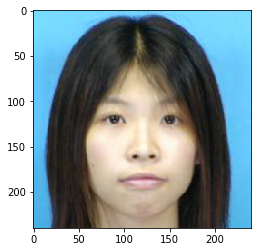

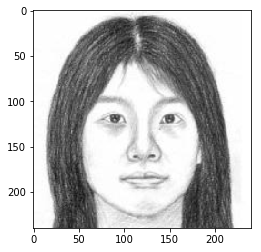

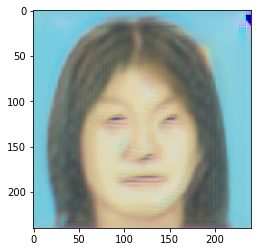

In [16]:
real_img = next(real_iter)[0]
sketch_img = next(sketch_iter)[0]

cuda_img = sketch_img.unsqueeze(0).cuda()
out = model(cuda_img)

#real image
plt.figure()
plt.imshow(np.transpose(real_img, (1, 2, 0)))
plt.show()

#sketch image
plt.figure()
plt.imshow(np.transpose(sketch_img, (1, 2, 0)))
plt.show()

#generated image
plt.figure()
plt.imshow(np.transpose(out[0].clamp_(0,1).detach().cpu().numpy(), (1, 2, 0)))
plt.show()

In [17]:
#saving model
torch.save(model.state_dict(), '/home/paperspace/models/sketch_to_real.pt')

In [18]:
#loading previously saved model
model.load_state_dict(torch.load('/home/paperspace/models/sketch_to_real.pt'))
model =model.eval()

Net(
  (c1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (c2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (c3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (res): Sequential(
    (0): Res1(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat